# Phenotyping lab notebook

This notebook is meant to help you perform phenotyping on your data by connecting to your database (following the OMOP schema) and import your data, perform phenotyping, and report the results


* config file placed in main directory will specify which version of python,and packages are needed

The next block imports important system packages needed

In [1]:
## base packages
import numpy as np
import pandas as pd
import time
from collections import Counter
from collections import OrderedDict
import os
import sys
import operator
import datetime

## Tensor Factorization Packages
sys.path.append("./code/tensor/")
import tensorIO
import time
import marbleAPR


## Initial Clustering Packages
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

## Consensus Cluster Determination Packages
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage



## Regression / Classification Packages
### feature selection / model selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

### classification
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### cross validation
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold

### metrics
from sklearn.metrics import roc_curve, auc
from scipy import interp

## COX
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

## Plotting packages
%matplotlib inline
import matplotlib.pyplot as plt



## database connectors
import sqlite3

## json
import json


/Users/rchen/miniconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/rchen/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## connect to database (OMOP)

first we need to connect to a database, and specify the data wanted for phenotyping
* replace database name and login info with your database info
* specify which concepts you want to include in the phenotyping task. these can include for example, medications and conditions
* database should follow the OMOP schema


### This Example:
* loaded phenotypes: phenotypes from Sutter Health
* patients to project: patients from CMS SynPUF


### Loading projection dataset
* load the CMS SynPUF dataset from OMOP database for CMS

In [73]:
import sqlite3


## connecting to the database
conn = sqlite3.connect('/path/to/query/database')
c = conn.cursor()



### database: grab concept table

concept table is REQUIRED. this table encodes the concept ID and description of the concep


In [74]:
c.execute('SELECT * FROM CONCEPT')
l_concept_table_columns = c.description
l_concept_table_columns_names = [x[0] for x in l_concept_table_columns]
df_CONCEPT = pd.DataFrame(c.fetchall(),columns = l_concept_table_columns_names )

## specify OMOP concepts used for phenotyping

below, please specify the clinical data tables used in the phenotyping task. 
* code this as a list of strings, each of which correspond to a table
* for this example we will use the following tables:
    - DRUG_EXPOSURE
    - CONDITION_OCCURRENCE

In [2]:
l_clinical_data_tables = ['CONDITION_OCCURRENCE' ]
l_clinical_data_date_columns = [ 'condition_start_date']
l_clinical_data_concept_id_columns = ['condition_source_concept_id']
l_clinical_data_feature_labels = ['CONDITION'] ## your label for each of the features

## specify any filtering of patients or concepts
below, please specify any filtering of patients or concepts you would like to perform. This can be done by either creating a list of concepts (within each of the data tables) as inclusions or exclusions to make.

note: the concept ID's in this example will likely differ from the concept ID's in your own OMOP database

In [3]:
## specify concepts to exclude here; if none, set l_concept_codes_exclude = []   
l_concept_codes_exclude = pd.read_csv('./data/df_CMS_hf_concept_id_exclusion.csv', header = None)[0]

### determining index dates, observation periods




In [4]:
l_concept_codes_exclude = [str(x) for x in l_concept_codes_exclude]

## Phenotyping: Data Processing

In this section some preliminary data processing is completed.
* some intermediate data frames are created which capture co-occurrences of events from the the selected tables

In [78]:
## create co-occurrences of events from selected data tables

## load selected data table, merge with other data tables

df_all_features = pd.DataFrame([])
print "generating co-occurrence data frames for NTF. tables used: ------"
l_tables_for_phenotyping = []
d_tables_for_phenotyping = dict()
for i in range(len(l_clinical_data_tables)):
    ## grab the table name and the required column numbers
    table_name = l_clinical_data_tables[i]
    concept_id_col = l_clinical_data_concept_id_columns[i]
    date_col = l_clinical_data_date_columns[i]
    this_data_table_label = l_clinical_data_feature_labels[i]
    
    print '\t', table_name
    #grab table from database
    c.execute('SELECT * FROM ' + table_name  )
    l_this_table_columns = c.description
    l_this_table_columns_names = [x[0] for x in l_this_table_columns]
    df_this_table = pd.DataFrame(data = c.fetchall(), columns = l_this_table_columns_names)
    
    
    df_this_table_subset = df_this_table[['person_id', date_col, concept_id_col ]] #person, date concept id
    df_merge_this_table_subset_concept = pd.merge(df_this_table_subset, df_CONCEPT[['concept_id', 'concept_name', 'concept_code']], left_on = concept_id_col, right_on='concept_id', how='outer' )

    ## exclude features that shoulde be excluded; this should be defined in previous code block
    df_merge_this_table_subset_concept = df_merge_this_table_subset_concept[ ~(df_merge_this_table_subset_concept['concept_id'].isin(l_concept_codes_exclude))]
    
    ## new dataframe: person, date, concept_name
    df_this_table_for_phenotyping = pd.DataFrame([])
    df_this_table_for_phenotyping[0] = df_merge_this_table_subset_concept['person_id']
    df_this_table_for_phenotyping[1] = df_merge_this_table_subset_concept[date_col]
    df_this_table_for_phenotyping[this_data_table_label] = df_merge_this_table_subset_concept['concept_name']
    
    df_this_table_for_phenotyping[1] = pd.to_datetime(df_this_table_for_phenotyping[1]) # convert to datetime
    df_this_table_for_phenotyping['concept_code'] = df_merge_this_table_subset_concept['concept_code']
    l_tables_for_phenotyping.append(df_this_table_for_phenotyping)
    d_tables_for_phenotyping[i] = df_this_table_for_phenotyping

generating co-occurrence data frames for NTF. tables used: ------
	CONDITION_OCCURRENCE


### * data processing: find co-occurrences of events

finding co-occurrences of all types of events and putting them in one event sequence dataframe

In [79]:
df_co_occurrences = d_tables_for_phenotyping[0]


In [80]:
for i in range(1, len(d_tables_for_phenotyping)):
    df_this_table = l_tables_for_phenotyping[i]
    patient_col = 0
    date_col = 1
    df_co_occurrences = pd.merge(df_co_occurrences, df_this_table, on = [patient_col, date_col])
    

In [81]:
df_co_occurrences = df_co_occurrences[df_co_occurrences[0] == df_co_occurrences[0]]
df_co_occurrences = df_co_occurrences[df_co_occurrences[1] == df_co_occurrences[1]]



In [82]:
d_counter_condition = Counter(df_co_occurrences['CONDITION'])


In [83]:
# d_counter_drug = Counter(df_co_occurrences['MEDICATION'])



In [84]:
## sort by value
d_counter_condition_sorted = sorted(d_counter_condition.items(), key=operator.itemgetter(1), reverse=True)
# d_counter_drug_sorted = sorted(d_counter_drug.items(), key=operator.itemgetter(1), reverse=True)

## list of conditions and drugs to include (top 250 by occurrence #)
l_conditions_include = [x[0] for x in d_counter_condition_sorted[0:250]]
# l_drugs_include = [x[0] for x in  d_counter_drug_sorted[0:250]]

## filter co-occurrences
df_co_occurrences = df_co_occurrences[df_co_occurrences['CONDITION'].isin(l_conditions_include)]
#df_co_occurrences = df_co_occurrences[df_co_occurrences['MEDICATION'].isin(l_drugs_include)]

del df_co_occurrences[1]
df_co_occurrences['VALUE'] = [1] * len(df_co_occurrences)

In [85]:

# df_co_occurrences.to_csv('./df_co_occurrences.csv', header = False, index = False)

## Phenotype Assignment: set data directories for storing results

set directories where results (phenotype definitions, this notebook, associated config files) are stored;

If you desire to give this notebook to somebody else, and have them re-use this, you would give them this directory

Note: please define the save directory with the variable 'dir_save_final_results'

In [6]:
## define the save folder
dir_save_final_results = './results/phenotyping_results/Projection_CMS_Sutter_CONDITION_binary_alpha_1.0_gamma_0.001_0.08_BINARY_R_10'

In [87]:
if os.path.exists(dir_save_final_results):
    print "error, specified results dir already exists, automatically create new one"
    l_results_folders = os.listdir('./results/')
    num_existing_results_folders=  len(l_results_folders)
    dir_save_final_results_final = './results/phenotyping_results/run_' + str(datetime.datetime.now())
    os.mkdir(dir_save_final_results_final)
else:
    dir_save_final_results_final = dir_save_final_results
    os.mkdir(dir_save_final_results_final)



## Phenotype Assignment: perform the assignment

Steps:

* load source phenotypes
* construct data structure for patients in source phenotype
* compute data structure (tensor) for the projection patients
* perform projection

In [7]:
### specify location of saved json 
file_saved_phenotypes_json = './results/phenotyping_results/CMS_CONDITION_alpha_1.0_gamma_0.001_0.05_BINARY/phenotypes.json'

In [89]:
### load json for saved phenotype
with open(file_saved_phenotypes_json, 'rb' ) as fp:
    d_loaded_phenotype = json.load(fp )

In [90]:
d_loaded_phenotype['config']

{u'alpha': 1,
 u'gamma': [0.001, 0.05],
 u'mode_labels': [u'PATIENT', u'DIAGNOSIS']}

In [91]:
d_loaded_phenotype_ICD_codes = dict()
for i in range(len(d_loaded_phenotype['phenotype_descriptions'])):
    l_codes_this_pheno = []
    for item in d_loaded_phenotype['phenotype_descriptions'][i]['features']['CONDITION_OCCURRENCE']:
        this_code = item['concept_code']
        l_codes_this_pheno.append(this_code)
    d_loaded_phenotype_ICD_codes[len(d_loaded_phenotype_ICD_codes)] = l_codes_this_pheno
        
        
        

In [96]:
## for each of the phenotypes from source data, determine which patients have the phenotype
d_phenotype_assignments = dict()
for i in range(len(d_loaded_phenotype_ICD_codes)):
    print 'projecting patients to phenotype ' , i
    l_icd_codes_this_pheno = d_loaded_phenotype_ICD_codes[i]
    df_pts_icd_codes_this_pheno = df_this_table_for_phenotyping[df_this_table_for_phenotyping['concept_code'].isin(l_icd_codes_this_pheno)]
    df_pts_icd_codes_this_pheno_unique = df_pts_icd_codes_this_pheno[[0,1,'CONDITION', 'concept_code']]
    df_pts_icd_codes_this_pheno_unique = df_pts_icd_codes_this_pheno_unique.drop_duplicates()
    df_pts_icd_codes_this_pheno_unique_count =  df_pts_icd_codes_this_pheno_unique.groupby([0]).count().reset_index()
    ## keep patients that have at least 3 of the features
    df_pts_icd_codes_this_pheno_atleast3 = df_pts_icd_codes_this_pheno_unique_count[df_pts_icd_codes_this_pheno_unique_count['concept_code'] >= 5]
    l_pts_assign_this_pheno = list(df_pts_icd_codes_this_pheno_atleast3[0])
    d_phenotype_assignments[i] = l_pts_assign_this_pheno

projecting patients to phenotype  0
projecting patients to phenotype  1
projecting patients to phenotype  2
projecting patients to phenotype  3
projecting patients to phenotype  4
projecting patients to phenotype  5
projecting patients to phenotype  6
projecting patients to phenotype  7
projecting patients to phenotype  8
projecting patients to phenotype  9


## display characteristics of phenotype assignment
* number of patients per phenotype

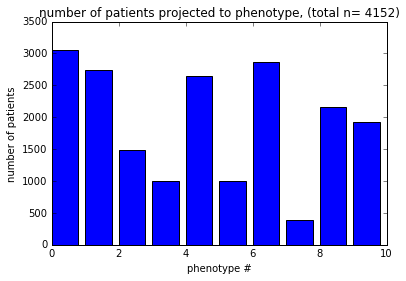

In [97]:
l_num_pts_per_pheno = [len(d_phenotype_assignments[x]) for x in d_phenotype_assignments]
num_pts_query_data = len(np.unique(df_this_table_for_phenotyping[0]))
plt.bar(range(len(l_num_pts_per_pheno)), l_num_pts_per_pheno)
plt.ylabel('number of patients')
plt.xlabel('phenotype #')
plt.title('number of patients projected to phenotype, (total n= ' + str(num_pts_query_data) + ')')

## Saving Results

This next section saves the results of the phenotype assignment.
A JSON object is created which saves the original phenotypes as well as the new phenotypes, 
with a description of which patients in the query dataset were assigned to the phenotypes
from the discovery dataset



In [62]:
## 1. create a new JSON object
## 2. copy the phenotype assignments from the discovery dataset
## 3. add the information about the query dataset
## 4. for each phenotypes, add assignments from the query dataset

In [67]:
d_phenotype_assignment_results = d_loaded_phenotype.copy()

In [72]:
for i in range(len(d_phenotype_assignment_results['phenotype_descriptions'])):
    d_phenotype_assignment_results['phenotype_descriptions'][i]['query_patients_assigned'] = d_phenotype_assignments[x]